In [1]:
import torch
import data_utils
from models.RSRAE import RSRLayer, RSRAutoEncoder
from training.RSRAE_train import train_kdd99, train_financial
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


# Hyperparameters

In [3]:
# choose dataset (kdd99, aapl, gm, axp)
dataset = "aapl"

In [4]:
# Data
num_features = 7
seq_len = 1
seq_stride = 10
gen_seq_len = seq_len
# Training
random_seed = 0
num_epochs = 50
batch_size = 8
lr = 0.01 # Peak lr
wd = 5e-7
# Model
d = 128
D = 128*4
lambda1=1.0
lambda2=1.0
threshold=0.8

# Load Data 

In [5]:
import numpy as np
import torch.utils.data as data
if dataset == "kdd99":
    train_dl, test_dl = data_utils.kdd99(seq_len, seq_stride, num_features, gen_seq_len, batch_size)
    steps_per_epoch=len(train_dl)
else:
    file_path = 'data/financial_data/Stocks/'+dataset+'.us.txt'
    tscv_dl_list = data_utils.load_stock_as_crossvalidated_timeseries(file_path, seq_len, seq_stride, gen_seq_len, batch_size, normalise=True)
    steps_per_epoch=len(tscv_dl_list[0][1])

# Model

In [6]:
model = RSRAutoEncoder(num_features*seq_len, d, D).to(DEVICE)
print(model)

RSRAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=512, bias=True)
  )
  (rsr): RSRLayer()
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)


# Loss and Optimizer

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

In [8]:
def RSRLoss(z,A,lambda1=lambda1, lambda2=lambda2, d=d, D=D):
    Id = torch.eye(d) # identity matrix
    z_hat = A @ z.view(z.size(0), D, 1)
    AtAz = (A.T @ z_hat).squeeze(2)
    
    term1 = torch.sum(torch.norm(z - AtAz, p=2))
    term2 = torch.norm(A @ A.T - Id, p=2) ** 2

    return lambda1 * term1 + lambda2 * term2

In [9]:
def L2p_loss(y_hat, y, p=1.0):
    return torch.sum(torch.pow(torch.norm(y - y_hat, p=2), p))

# Train & Evaluate

In [10]:
if dataset == "kdd99":
    train_kdd99(model, train_dl, test_dl, num_epochs, L2p_loss, RSRLoss, optimizer, scheduler, threshold, DEVICE)
else:
    train_financial(model, tscv_dl_list, num_epochs, L2p_loss, RSRLoss, optimizer, scheduler, threshold, DEVICE)

Epoch 0 loss: 13.272458934783936
Epoch 1 loss: 11.637846755981446
Epoch 2 loss: 10.653204488754273
Epoch 3 loss: 10.249801397323608
Epoch 4 loss: 10.093657445907592
Epoch 5 loss: 9.925625228881836
Epoch 6 loss: 9.75029788017273
Epoch 7 loss: 9.613242959976196
Epoch 8 loss: 9.510754203796386
Epoch 9 loss: 9.436403894424439
Epoch 10 loss: 9.378304147720337
Epoch 11 loss: 9.317265796661378
Epoch 12 loss: 9.253662204742431
Epoch 13 loss: 9.197364807128906
Epoch 14 loss: 9.14647421836853
Epoch 15 loss: 9.095189714431763
Epoch 16 loss: 9.042245674133301
Epoch 17 loss: 8.987722635269165
Epoch 18 loss: 8.934026908874511
Epoch 19 loss: 8.87970199584961
Epoch 20 loss: 8.822661399841309
Epoch 21 loss: 8.764950942993163
Epoch 22 loss: 8.706610774993896
Epoch 23 loss: 8.648844575881958
Epoch 24 loss: 8.592875051498414
Epoch 25 loss: 8.540070199966431
Epoch 26 loss: 8.491299390792847
Epoch 27 loss: 8.448064231872559
Epoch 28 loss: 8.410270500183106
Epoch 29 loss: 8.37824034690857
Epoch 30 loss: 8.35

Epoch 44 loss: 5.665998118264334
Epoch 45 loss: 5.659272579919724
Epoch 46 loss: 5.652724981307983
Epoch 47 loss: 5.655150651931763
Epoch 48 loss: 5.6535611266181585
Epoch 49 loss: 5.656589803241548
EM: 0.0015176722056544345, MV: 88.99037034096719
Final results - EM: 0.002433275837541103 MV: 821.6095471759702


# Generate Samples

In [26]:
if dataset == "kdd99":
    print("TBA")
else:
    batch = next(iter(tscv_dl_list[4][1]))
    x = batch[0].squeeze()
    y = batch[1].squeeze()
    enc, z, latent, A = model(x.to(DEVICE))
    z = z.cpu().detach()

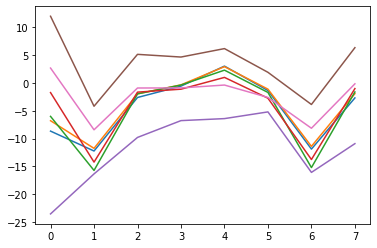

In [28]:
plt.plot(z)

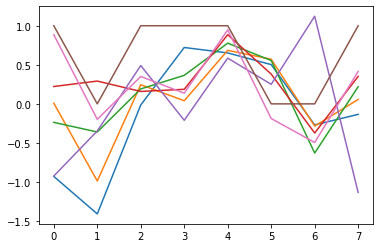

In [25]:
plt.plot(x)